# Avance 3. Baseline

## Proyecto Integrador - MNA

### Equipo 21

Integrantes del equipo:
- Guadalupe Esmeralda González Maldonado - A01795767
- Marco Daniel Cameros Bobadilla - A01795655
- Jesús Armando Anaya Orozco - A01795464

Nombre del dataset: DDR2019

## Contexto y objetivo de este notebook

Este notebook inicia con un baseline para clasificación de retinopatía diabética a partir de imágenes de fondo de ojo.

Un baseline es la primera solución razonable y reproducible. Sirve como punto de comparación para decidir si conviene avanzar a un enfoque más complejo.

- **Parte 1 (baseline principal)**: DenseNet-121 como extractor de características + XGBoost como clasificador. Se busca una solución rápida, estable e interpretable.
- **Parte 2 (comparación avanzada)**: se evalúa una alternativa más compleja para validar si la mayor complejidad agrega valor real.

### Referencia usada para el baseline principal

La selección del baseline se guía por literatura reciente en detección de retinopatía diabética con transferencia de aprendizaje y clasificación robusta.


## 1) Setup del proyecto y dependencias

Esta sección define entorno, rutas y librerías para asegurar reproducibilidad. Es muy importante que la ejecución sea consistente entre corridas para comparar resultados de forma justa.

Se mantiene coherencia con Avance 2 en criterios de balanceo y transformaciones base. Esto conviene para no cambiar demasiadas variables al mismo tiempo.

Además, se separa el preprocesamiento por backbone porque cada arquitectura espera formatos de entrada específicos (tamaño y normalización). Así se busca evitar sesgos por incompatibilidad en la preparación de datos.


In [1]:
import os
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import DenseNet121_Weights
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

from sam_ml.datasets import DDR2019Dataset

In [2]:
# Resolver la raíz del proyecto de forma robusta.
_path = Path.cwd()
while _path != _path.parent and not (_path / "pyproject.toml").exists():
    _path = _path.parent
PROJECT_ROOT = _path if (_path / "pyproject.toml").exists() else Path.cwd()
os.chdir(PROJECT_ROOT)

# Fijar semillas para reproducibilidad.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Dataset base para la Parte 1 (baseline).
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "ddr2019"
LABELS_CSV = DATA_DIR / "labels.csv"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR (Parte 1): {DATA_DIR}")
print(f"labels.csv existe: {LABELS_CSV.exists()}")


PROJECT_ROOT: /home/anaya/Development/Robomous/sam-ai
DATA_DIR (Parte 1): /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019
labels.csv existe: True


In [3]:
# Cargar dataset base (una sola imagen por muestra) y validar contrato de salida.
base_dataset_train = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="train",
    train_ratio=0.8,
    val_ratio=0.2,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

base_dataset_all = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="all",
    transform=transforms.ToTensor(),
    random_state=SEED,
)

image_sample, label_sample = base_dataset_train[0]

print(f"Muestras train: {len(base_dataset_train)}")
print(f"Muestras all: {len(base_dataset_all)}")
print(f"Shape imagen: {tuple(image_sample.shape)}")
print(f"Label de ejemplo: {label_sample}")


Muestras train: 10015
Muestras all: 12522
Shape imagen: (3, 512, 512)
Label de ejemplo: 0


## 2) Configuración de preprocesamiento para el baseline

En esta primera parte solo se prepara lo necesario para el baseline con DenseNet-121.

Muy importante: se usa la normalización esperada por el modelo preentrenado para reducir desajustes entre la distribución de entrada y los pesos aprendidos en ImageNet.

En términos simples, el "input size esperado" es el tamaño de imagen para el que la red fue entrenada originalmente. Mantener ese tamaño y esa normalización ayuda a sostener un comportamiento estable.


In [5]:
# Definir pesos de referencia para el baseline.
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_preset = densenet_weights.transforms()

densenet_norm_mean = torch.tensor(densenet_preset.mean, dtype=torch.float32)
densenet_norm_std = torch.tensor(densenet_preset.std, dtype=torch.float32)

print("Normalización del baseline (DenseNet-121):")
print(f"  input_size esperado: {densenet_preset.crop_size[0]} x {densenet_preset.crop_size[0]}")
print(f"  mean: {densenet_norm_mean.tolist()}")
print(f"  std: {densenet_norm_std.tolist()}")


Normalización del baseline (DenseNet-121):
  input_size esperado: 224 x 224
  mean: [0.48500001430511475, 0.4560000002384186, 0.4059999883174896]
  std: [0.2290000021457672, 0.2240000069141388, 0.22499999403953552]


## 3) Transformaciones de normalización del baseline

Se aplica normalización compatible con DenseNet-121 usando estadísticas de ImageNet.

Estas transformaciones preparan la imagen para que el backbone "vea" los datos en condiciones similares a su preentrenamiento. Eso reduce el riesgo de degradación por cambio de escala o distribución.

Conviene mantener la lógica de augmentación y balanceo coherente con Avance 2 para no mezclar demasiados cambios metodológicos al mismo tiempo.


In [6]:
def normalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Normalizar tensor RGB con media/desviación esperadas por un backbone."""
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype).clamp_min(1e-8)
    return (x - m) / s


def denormalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Deshacer normalización RGB para visualización."""
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype)
    return x * s + m


def preprocess_image_for_densenet(x: torch.Tensor) -> torch.Tensor:
    """Preprocesar imagen para baseline con DenseNet-121."""
    x = x.float().clamp(0.0, 1.0)
    return normalize_with_stats_torch(x, densenet_norm_mean, densenet_norm_std)


## 4) Balanceo de clases

En retinopatía diabética existe desbalance de clases. Si se entrena sin control, el modelo puede favorecer clases mayoritarias y fallar en clases menos frecuentes.

Criterios operativos:

- **Minoritarias**: `count < mean_count * 0.5`.
- **Aumento de exposición**: `AUGMENTATION_MULTIPLIER = 5` (original + HFlip + VFlip + Rot1 + Rot2).
- **Control de dominancia mayoritaria**: downsampling con `MAJORITY_CAP = 3500` si `count > mean_count` y `count > MAJORITY_CAP`.

Conexión con rúbrica: este punto justifica por qué macro-F1 y macro-recall son muy importantes. En escenarios desbalanceados, accuracy puede verse bien y aun así ocultar mal desempeño en clases minoritarias.

**Costo/beneficio**: balancear mejora cobertura entre clases y suele hacer más justa la evaluación, pero incrementa costo de cómputo por el volumen de muestras aumentadas.


In [7]:
train_rows = base_dataset_train._rows.reset_index(drop=True).copy()

class_counts = train_rows["label"].value_counts().sort_index()
mean_count = class_counts.mean()
minority_threshold = mean_count * 0.5
minority_classes = set(class_counts[class_counts < minority_threshold].index.tolist())

AUGMENTATION_MULTIPLIER = 5
MAJORITY_CAP = 3500

augmentation_targets: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_minority = int(label) in minority_classes
    target_count = int(count) * AUGMENTATION_MULTIPLIER if is_minority else int(count)
    augmentation_targets[int(label)] = {
        "current_count": int(count),
        "target_count": int(target_count),
        "multiplier": AUGMENTATION_MULTIPLIER if is_minority else 1,
        "is_minority": is_minority,
    }

downsampling_ratios: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_majority = float(count) > float(mean_count)
    if is_majority and int(count) > MAJORITY_CAP:
        new_count = MAJORITY_CAP
        reduction_pct = (1.0 - (new_count / int(count))) * 100.0
    else:
        new_count = int(count)
        reduction_pct = 0.0
    downsampling_ratios[int(label)] = {
        "current_count": int(count),
        "new_count": int(new_count),
        "reduction_pct": float(reduction_pct),
        "is_downsampled": bool(is_majority and int(count) > MAJORITY_CAP),
    }

final_counts: dict[int, int] = {}
for label in sorted(class_counts.index.tolist()):
    if int(label) in minority_classes:
        final_counts[int(label)] = int(augmentation_targets[int(label)]["target_count"])
    else:
        final_counts[int(label)] = int(downsampling_ratios[int(label)]["new_count"])

original_imbalance_ratio = float(class_counts.max() / class_counts.min())
final_counts_series = pd.Series(final_counts).sort_index()
final_imbalance_ratio = float(final_counts_series.max() / final_counts_series.min())

print("Resumen de balanceo (Parte 1):")
print(f"  class_counts: {class_counts.to_dict()}")
print(f"  mean_count: {mean_count:.2f}")
print(f"  minority_threshold (50% mean): {minority_threshold:.2f}")
print(f"  minority_classes: {sorted(list(minority_classes))}")
print(f"  AUGMENTATION_MULTIPLIER: {AUGMENTATION_MULTIPLIER}")
print(f"  MAJORITY_CAP: {MAJORITY_CAP}")
print(f"  ratio original: {original_imbalance_ratio:.2f}:1")
print(f"  ratio final: {final_imbalance_ratio:.2f}:1")


Resumen de balanceo (Parte 1):
  class_counts: {0: 5012, 1: 504, 2: 3581, 3: 188, 4: 730}
  mean_count: 2003.00
  minority_threshold (50% mean): 1001.50
  minority_classes: [1, 3, 4]
  AUGMENTATION_MULTIPLIER: 5
  MAJORITY_CAP: 3500
  ratio original: 26.66:1
  ratio final: 3.88:1


## 5) Utilidades de balanceo y augmentación para la Parte 1

En esta sección se dejan funciones reutilizables para muestreo balanceado por clase y augmentación geométrica reproducible.

- Muestreo con control de clases mayoritarias.
- Exposición adicional para clases minoritarias.
- Rotaciones y flips deterministas por índice.

Esto conviene porque el baseline y la comparación posterior mantienen reglas de datos consistentes.


In [8]:
def _sample_indices_per_class(
    rows: pd.DataFrame,
    majority_cap: int,
    seed: int,
) -> list[int]:
    """Aplicar downsampling por clase para mayoritarias y mantener el resto."""
    rng = np.random.default_rng(seed)
    selected: list[int] = []

    counts = rows["label"].value_counts().sort_index()
    mean_count_local = counts.mean()

    for label in sorted(counts.index.tolist()):
        cls_rows = rows[rows["label"] == label]
        cls_indices = cls_rows.index.to_numpy()
        is_majority = counts[label] > mean_count_local

        if is_majority and len(cls_indices) > majority_cap:
            chosen = rng.choice(cls_indices, size=majority_cap, replace=False)
            selected.extend(chosen.tolist())
        else:
            selected.extend(cls_indices.tolist())

    return selected


def _build_augmented_sample_list(
    rows: pd.DataFrame,
    selected_indices: list[int],
    minority_set: set[int],
) -> list[tuple[int, int]]:
    """Construir lista (base_index, aug_id) según clase minoritaria/no minoritaria."""
    samples: list[tuple[int, int]] = []
    for idx in selected_indices:
        label = int(rows.loc[idx, "label"])
        if label in minority_set:
            # 0 = original, 1 = hflip, 2 = vflip, 3 = rot1, 4 = rot2
            for aug_id in (0, 1, 2, 3, 4):
                samples.append((int(idx), int(aug_id)))
        else:
            samples.append((int(idx), 0))
    return samples


def _draw_rotation_angles(rng: np.random.Generator) -> tuple[float, float]:
    """Generar dos ángulos distintos con magnitud en [10,15]."""

    def _one_angle() -> float:
        mag = float(rng.uniform(10.0, 15.0))
        sign = -1.0 if rng.random() < 0.5 else 1.0
        return sign * mag

    angle1 = _one_angle()
    angle2 = _one_angle()
    while abs(angle2 - angle1) < 1e-6:
        angle2 = _one_angle()
    return angle1, angle2


print("Helpers de balanceo y augmentación listos para reutilizar.")


Helpers de balanceo y augmentación listos para reutilizar.


## 6) Verificación inicial del pipeline de la Parte 1

Esta sección valida integridad de datos antes de entrenar el baseline.

- Validación de forma de tensores y etiquetas.
- Comparación de distribución original vs distribución objetivo tras balanceo.
- Revisión visual de muestras para detectar problemas de preprocesamiento.

Este control es muy importante para asegurar que el resultado del baseline sea confiable y comparable.


In [10]:
# Verificación rápida del dataset base (Parte 1).
batch_size = 8
baseline_loader = DataLoader(
    base_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

images_batch, labels_batch = next(iter(baseline_loader))

print("Sanity check:")
print(f"  images_batch shape: {tuple(images_batch.shape)}")
print(f"  labels_batch shape: {tuple(labels_batch.shape)}")
print(f"  rango imágenes: [{float(images_batch.min()):.3f}, {float(images_batch.max()):.3f}]")


Sanity check:
  images_batch shape: (8, 3, 512, 512)
  labels_batch shape: (8,)
  rango imágenes: [0.000, 1.000]


=== Resumen de pipeline ===
DATA_DIR: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019
Split train base: 10015
Split all base: 12522
images_batch shape: (8, 3, 512, 512)
labels_batch shape: (8,)
Distribución original (train): {0: 5012, 1: 504, 2: 3581, 3: 188, 4: 730}
Distribución final objetivo: {0: 3500, 1: 2520, 2: 3500, 3: 940, 4: 3650}
Ratio original: 26.66:1
Ratio final: 3.88:1


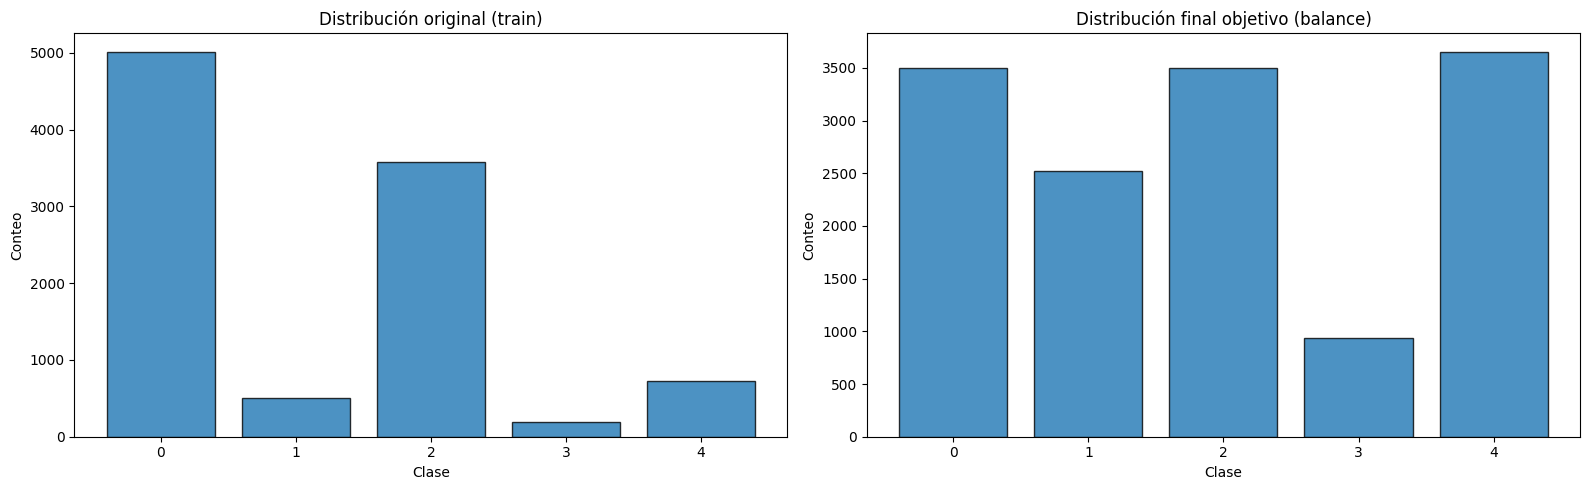

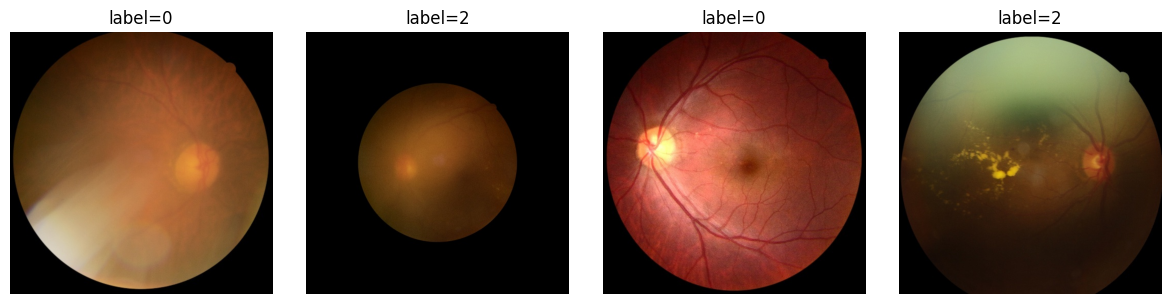

In [11]:
print("=== Resumen de pipeline ===")
print(f"DATA_DIR: {DATA_DIR}")
print(f"Split train base: {len(base_dataset_train)}")
print(f"Split all base: {len(base_dataset_all)}")
print(f"images_batch shape: {tuple(images_batch.shape)}")
print(f"labels_batch shape: {tuple(labels_batch.shape)}")
print(f"Distribución original (train): {class_counts.to_dict()}")
print(f"Distribución final objetivo: {final_counts_series.to_dict()}")
print(f"Ratio original: {original_imbalance_ratio:.2f}:1")
print(f"Ratio final: {final_imbalance_ratio:.2f}:1")

# Graficar distribución original vs final objetivo.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

classes_sorted = sorted(class_counts.index.tolist())
x = np.arange(len(classes_sorted))
orig_values = [int(class_counts.loc[c]) for c in classes_sorted]
final_values = [int(final_counts_series.loc[c]) for c in classes_sorted]

axes[0].bar(x, orig_values, edgecolor="black", alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes_sorted)
axes[0].set_title("Distribución original (train)")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Conteo")

axes[1].bar(x, final_values, edgecolor="black", alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes_sorted)
axes[1].set_title("Distribución final objetivo (balance)")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

# Mostrar muestras del batch de la Parte 1.
n_show = min(4, images_batch.shape[0])
fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3))
if n_show == 1:
    axes = np.array([axes])

for i in range(n_show):
    image_vis = images_batch[i].detach().cpu().clamp(0.0, 1.0)
    axes[i].imshow(np.transpose(image_vis.numpy(), (1, 2, 0)))
    axes[i].set_title(f"label={int(labels_batch[i])}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## Parte 1) Baseline (DenseNet-121 como extractor + XGBoost)

### A) Por qué este es nuestro baseline

Un baseline conviene cuando hay datos de imagen limitados y se necesita una referencia reproducible en tiempo razonable.

- **DenseNet-121 preentrenado (extractor)**: reutiliza representación visual robusta y reduce costo de entrenamiento.
- **XGBoost (clasificador)**: entrena rápido, es estable y vale la pena porque permite analizar importancia de características.

Este enfoque se usa como referencia principal para decidir si un modelo más complejo realmente mejora resultados.

### B) Qué significa "características" en esta parte

Se combinan dos tipos de señal:

- **Características profundas** (embeddings) obtenidas por DenseNet-121.
- **Características globales simples** calculadas sobre la imagen (cuando están disponibles en el pipeline), para aportar contexto complementario.

Muy importante: incluir variables irrelevantes puede introducir ruido y reducir generalización.

### C) Relevancia de características

Se elige XGBoost porque incorpora análisis de importancia de forma embebida. Esto permite interpretar qué componentes aportan más a la decisión.

En la interpretación se busca:

- identificar las características con mayor contribución,
- revisar si el modelo depende demasiado de un conjunto pequeño de variables (señal potencial de sobreajuste).

### D) Regla de desempeño mínimo

Criterio mínimo explícito:

**El baseline debe superar claramente un predictor ingenuo que siempre predice la clase mayoritaria.**

Si no lo supera, conviene revisar calidad de señal de datos y consistencia del pipeline antes de escalar complejidad.

In [12]:
def _imagenet_stats_from_densenet() -> tuple[list[float], list[float]]:
    weights = DenseNet121_Weights.DEFAULT
    mean = list(weights.meta.get("mean", (0.485, 0.456, 0.406)))
    std = list(weights.meta.get("std", (0.229, 0.224, 0.225)))
    return mean, std


def _to_gray(x: torch.Tensor) -> torch.Tensor:
    """Convertir RGB->grayscale (tensor CHW en [0,1])."""
    r, g, b = x[0], x[1], x[2]
    return (0.2989 * r + 0.5870 * g + 0.1140 * b).clamp(0.0, 1.0)


def _global_features(x: torch.Tensor, hist_bins: int = 16) -> torch.Tensor:
    """Features globales: mean/std por canal + histograma en escala de grises."""
    ch_mean = x.mean(dim=(1, 2))
    ch_std = x.std(dim=(1, 2), unbiased=False)

    gray = _to_gray(x)
    hist = torch.histc(gray, bins=int(hist_bins), min=0.0, max=1.0)
    hist = hist / (hist.sum().clamp_min(1.0))

    return torch.cat([ch_mean, ch_std, hist], dim=0).float()


def _apply_geometry(
    image: torch.Tensor,
    aug_id: int,
    idx: int,
    seed: int,
) -> torch.Tensor:
    """Aplicar augmentación geométrica simple (reproducible por índice)."""
    if int(aug_id) == 0:
        return image
    if int(aug_id) == 1:
        return TF.hflip(image)
    if int(aug_id) == 2:
        return TF.vflip(image)

    rng = np.random.default_rng(int(seed) + int(idx))

    def _one_angle() -> float:
        mag = float(rng.uniform(10.0, 15.0))
        sign = -1.0 if rng.random() < 0.5 else 1.0
        return sign * mag

    angle1 = _one_angle()
    angle2 = _one_angle()
    while abs(angle2 - angle1) < 1e-6:
        angle2 = _one_angle()

    angle = angle1 if int(aug_id) == 3 else angle2
    return TF.rotate(
        image,
        angle=float(angle),
        interpolation=InterpolationMode.BILINEAR,
        fill=0.0,
    )


class BaselineSingleFeatureDataset(Dataset):
    """Dataset para baseline (ddr2019): imagen procesada para DenseNet + features globales extra."""

    def __init__(
        self,
        base_dataset: "DDR2019Dataset",
        samples: list[tuple[int, int]],
        seed: int,
        image_size: int = 224,
        hist_bins: int = 16,
    ) -> None:
        self.base_dataset = base_dataset
        self.samples = list(samples)
        self.seed = int(seed)
        self.image_size = int(image_size)
        self.hist_bins = int(hist_bins)

        self.mean, self.std = _imagenet_stats_from_densenet()

    def __len__(self) -> int:
        return len(self.samples)

    def _prep_for_densenet(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Redimensionar a 224x224 (para features globales consistentes) antes de normalizar.
        x = TF.resize(
            x,
            [self.image_size, self.image_size],
            interpolation=InterpolationMode.BILINEAR,
            antialias=True,
        )
        x = x.float().clamp(0.0, 1.0)

        extra = _global_features(x, hist_bins=self.hist_bins)
        x_norm = TF.normalize(x, mean=self.mean, std=self.std)
        return x_norm, extra

    def __getitem__(self, item_idx: int) -> dict[str, torch.Tensor]:
        base_index, aug_id = self.samples[int(item_idx)]
        image, label = self.base_dataset[int(base_index)]
        image = image.float().clamp(0.0, 1.0)

        image_aug = _apply_geometry(
            image,
            aug_id=int(aug_id),
            idx=int(base_index),
            seed=self.seed,
        )

        image_in, extra = self._prep_for_densenet(image_aug)

        return {
            "image": image_in,
            "extra": extra,
            "label": torch.tensor(int(label), dtype=torch.long),
        }


def build_densenet121_feature_extractor() -> nn.Module:
    """DenseNet-121 preentrenado como extractor: salida (B, 1024)."""
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Identity()

    # Congelar parámetros: solo extracción.
    for p in model.parameters():
        p.requires_grad = False

    return model


@torch.no_grad()
def extract_baseline_features(
    feature_model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> tuple[np.ndarray, np.ndarray]:
    """Extraer features concatenadas (DenseNet + extras)."""
    feature_model = feature_model.to(device)
    feature_model.eval()

    feats: list[np.ndarray] = []
    labels: list[np.ndarray] = []

    for batch in tqdm(loader, desc="Extrayendo features (DenseNet)", total=len(loader)):
        image = batch["image"].to(device, non_blocking=True)
        extra = batch["extra"].to(device, non_blocking=True)
        y = batch["label"].detach().cpu().numpy()

        f = feature_model(image)
        f = torch.cat([f, extra], dim=1)

        feats.append(f.detach().cpu().numpy())
        labels.append(y)

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)

    print("Feature matrix shape:", X.shape)
    return X, y


Dataset baseline (ddr2019)
  DATA_DIR_BASELINE: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019
  train: 10015
  val  : 2507
Resumen de balanceo (baseline/train):
  class_counts: {0: 5012, 1: 504, 2: 3581, 3: 188, 4: 730}
  mean_count: 2003.00
  minority_threshold (50% mean): 1001.50
  minority_classes: [1, 3, 4]
  AUGMENTATION_MULTIPLIER: 5
  MAJORITY_CAP: 3500
Dispositivo para extracción de features (baseline): cuda


Extrayendo features (DenseNet):   0%|          | 0/441 [00:00<?, ?it/s]

Feature matrix shape: (14110, 1046)


Extrayendo features (DenseNet):   0%|          | 0/79 [00:00<?, ?it/s]

Feature matrix shape: (2507, 1046)
num_classes (baseline): 5
Entrenando XGBoost...

Resultados en VAL (baseline)
Accuracy : 0.7495013960909453
Precision: 0.7370346348177882
Recall   : 0.7495013960909453
F1-score : 0.7388725216332603

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1254
           1       0.22      0.10      0.14       126
           2       0.68      0.74      0.71       896
           3       0.69      0.19      0.30        48
           4       0.66      0.72      0.69       183

    accuracy                           0.75      2507
   macro avg       0.62      0.52      0.54      2507
weighted avg       0.74      0.75      0.74      2507



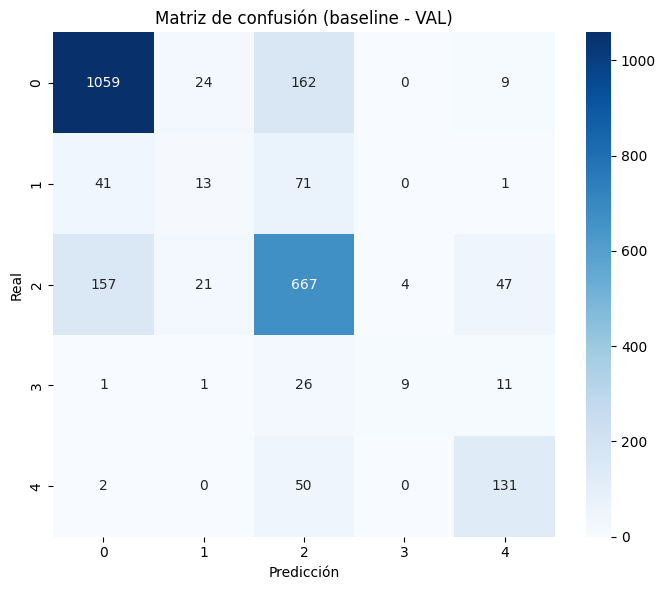

In [13]:
# 1) Cargar dataset simple (ddr2019).
DATA_DIR_BASELINE = PROJECT_ROOT / "data" / "processed" / "ddr2019"

baseline_train_ds = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="train",
    train_ratio=0.8,
    val_ratio=0.2,
    transform=transforms.ToTensor(),
    random_state=SEED,
)
baseline_val_ds = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="val",
    train_ratio=0.8,
    val_ratio=0.2,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

print("Dataset baseline (ddr2019)")
print(f"  DATA_DIR_BASELINE: {DATA_DIR_BASELINE}")
print(f"  train: {len(baseline_train_ds)}")
print(f"  val  : {len(baseline_val_ds)}")

# 2) Balanceo coherente con nuestro enfoque (sobre el split de entrenamiento).
train_rows_baseline = baseline_train_ds._rows.reset_index(drop=True).copy()
class_counts_baseline = train_rows_baseline["label"].value_counts().sort_index()
mean_count_baseline = class_counts_baseline.mean()
minority_threshold_baseline = mean_count_baseline * 0.5
baseline_minority_classes = set(
    class_counts_baseline[class_counts_baseline < minority_threshold_baseline].index.tolist()
)

BASELINE_AUGMENTATION_MULTIPLIER = 5
BASELINE_MAJORITY_CAP = 3500

print("Resumen de balanceo (baseline/train):")
print(f"  class_counts: {class_counts_baseline.to_dict()}")
print(f"  mean_count: {mean_count_baseline:.2f}")
print(f"  minority_threshold (50% mean): {minority_threshold_baseline:.2f}")
print(f"  minority_classes: {sorted(int(x) for x in baseline_minority_classes)}")
print(f"  AUGMENTATION_MULTIPLIER: {BASELINE_AUGMENTATION_MULTIPLIER}")
print(f"  MAJORITY_CAP: {BASELINE_MAJORITY_CAP}")

# Reusar helpers ya definidos en el notebook (_sample_indices_per_class, _build_augmented_sample_list).
selected_train = _sample_indices_per_class(train_rows_baseline, BASELINE_MAJORITY_CAP, SEED)
train_samples = _build_augmented_sample_list(
    train_rows_baseline,
    selected_train,
    set(int(x) for x in baseline_minority_classes),
)

# Para validación no se aplica balanceo ni augmentación.
val_samples = [(int(i), 0) for i in range(len(baseline_val_ds))]

train_fe_ds = BaselineSingleFeatureDataset(
    base_dataset=baseline_train_ds,
    samples=train_samples,
    seed=SEED,
    image_size=224,
    hist_bins=16,
)
val_fe_ds = BaselineSingleFeatureDataset(
    base_dataset=baseline_val_ds,
    samples=val_samples,
    seed=SEED,
    image_size=224,
    hist_bins=16,
)

num_workers = min(4, os.cpu_count() or 1)
train_loader = DataLoader(
    train_fe_ds,
    batch_size=32,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_fe_ds,
    batch_size=32,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# 3) Extraer features con DenseNet (usa CUDA si está disponible).
FEATURE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo para extracción de features (baseline): {FEATURE_DEVICE}")

if FEATURE_DEVICE.type == "cuda":
    # Recomendado para GPUs con Tensor Cores.
    torch.set_float32_matmul_precision("high")

feature_model = build_densenet121_feature_extractor()

X_train, y_train = extract_baseline_features(feature_model, train_loader, FEATURE_DEVICE)
X_val, y_val = extract_baseline_features(feature_model, val_loader, FEATURE_DEVICE)

# 4) Entrenar clasificador tradicional (XGBoost).
try:
    from xgboost import XGBClassifier
except Exception as e:
    raise ImportError(
        "No se pudo importar xgboost en este entorno. "
        "Asegura que tu kernel está usando el ambiente correcto (uv/.venv) y que xgboost está instalado. "
        f"Detalle: {e}"
    )

num_classes_local = int(np.unique(y_train).shape[0])
print(f"num_classes (baseline): {num_classes_local}")

xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes_local,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    eval_metric="mlogloss",
)

print("Entrenando XGBoost...")
xgb_model.fit(X_train, y_train)

# 5) Evaluación sobre VAL.
y_pred = xgb_model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_val, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)

print("\nResultados en VAL (baseline)")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("\nClassification report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

# 6) Matriz de confusión.
labels_sorted = sorted(int(x) for x in np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels_sorted)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
)
plt.title("Matriz de confusión (baseline - VAL)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


## Parte 2) Entrenamiento (DualChannel + PyTorch Lightning)

Esta parte incorpora un enfoque más complejo de comparación: un modelo dual (InceptionV3 + VGG16) inspirado en la línea de trabajo de *Identification of Diabetic Retinopathy Using Weighted Fusion Deep Learning Based on Dual-Channel Fundus Scans*.

No se usa como única referencia, sino como contraste frente al baseline de la Parte 1 para medir si la complejidad agrega valor real en este dataset.

Puntos importantes:

- **Evitar doble normalización**: el wrapper Lightning del modelo (`dual_channel`) ya normaliza internamente con estadísticas de ImageNet. Por eso, al `DataLoader` se entregan tensores en `[0,1]` sin aplicar otra normalización adicional.
- **Coherencia de datos**: se reutiliza la lógica de balanceo y augmentación geométrica síncrona.
- **Smoke run**: se hace una corrida corta para verificar que el pipeline completo (datos, modelo, entrenamiento y validación) funciona de extremo a extremo.

Aunque sea más complejo, vale la pena compararlo porque ayuda a decidir con evidencia si conviene adoptar un modelo dual como base del proyecto.


In [14]:
# Dataset de entrenamiento de la Parte 2: carga y preparación específica del enfoque dual.
from typing import Callable

from sam_ml.datasets import DDR2019DualFiltersDataset


DATA_DIR_DUAL = PROJECT_ROOT / "data" / "processed" / "ddr2019_dualfilters"

base_dataset_train = DDR2019DualFiltersDataset(
    data_dir=DATA_DIR_DUAL,
    split="train",
    train_ratio=0.8,
    val_ratio=0.2,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

train_rows = base_dataset_train._rows.reset_index(drop=True).copy()
class_counts = train_rows["label"].value_counts().sort_index()
mean_count = class_counts.mean()
minority_threshold = mean_count * 0.5
minority_classes = set(class_counts[class_counts < minority_threshold].index.tolist())
MAJORITY_CAP = 3500

print("Resumen de configuración dual (Parte 2):")
print(f"  DATA_DIR_DUAL: {DATA_DIR_DUAL}")
print(f"  train size: {len(base_dataset_train)}")
print(f"  class_counts: {class_counts.to_dict()}")
print(f"  minority_classes: {sorted(list(minority_classes))}")
print(f"  MAJORITY_CAP: {MAJORITY_CAP}")


def preprocess_clahe_for_training(x: torch.Tensor) -> torch.Tensor:
    """Retorna tensor en [0,1] sin normalización (la hace el modelo)."""
    return x.float().clamp(0.0, 1.0)


def preprocess_ceced_for_training(x: torch.Tensor) -> torch.Tensor:
    """Retorna tensor en [0,1] sin normalización (la hace el modelo)."""
    return x.float().clamp(0.0, 1.0)


class BalancedAugmentedDualDatasetForTraining(Dataset):
    """Dataset dual balanceado con augmentación síncrona, sin normalización."""

    def __init__(
        self,
        base_dataset: DDR2019DualFiltersDataset,
        clahe_transform: Callable[[torch.Tensor], torch.Tensor],
        ceced_transform: Callable[[torch.Tensor], torch.Tensor],
        minority_set: set[int],
        majority_cap: int = 3500,
        seed: int = 42,
    ) -> None:
        self.base_dataset = base_dataset
        self.clahe_transform = clahe_transform
        self.ceced_transform = ceced_transform
        self.minority_set = set(int(x) for x in minority_set)
        self.majority_cap = int(majority_cap)
        self.seed = int(seed)

        rows = base_dataset._rows.reset_index(drop=True).copy()
        self.rows = rows

        selected = _sample_indices_per_class(rows, self.majority_cap, self.seed)
        self.samples = _build_augmented_sample_list(rows, selected, self.minority_set)

    def __len__(self) -> int:
        return len(self.samples)

    def _apply_sync_geometry(
        self,
        clahe: torch.Tensor,
        ceced: torch.Tensor,
        aug_id: int,
        idx: int,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Aplicar misma geometría en ambas ramas."""
        if aug_id == 0:
            return clahe, ceced
        if aug_id == 1:
            return TF.hflip(clahe), TF.hflip(ceced)
        if aug_id == 2:
            return TF.vflip(clahe), TF.vflip(ceced)

        rng = np.random.default_rng(self.seed + idx)
        angle1, angle2 = _draw_rotation_angles(rng)
        angle = angle1 if aug_id == 3 else angle2

        clahe_out = TF.rotate(
            clahe,
            angle=angle,
            interpolation=InterpolationMode.BILINEAR,
            fill=0.0,
        )
        ceced_out = TF.rotate(
            ceced,
            angle=angle,
            interpolation=InterpolationMode.NEAREST,
            fill=0.0,
        )
        return clahe_out, ceced_out

    def __getitem__(self, item_idx: int) -> tuple[tuple[torch.Tensor, torch.Tensor], int]:
        base_index, aug_id = self.samples[item_idx]
        (clahe, ceced), label = self.base_dataset[int(base_index)]

        clahe_aug, ceced_aug = self._apply_sync_geometry(
            clahe.float(),
            ceced.float(),
            int(aug_id),
            int(base_index),
        )

        clahe_processed = self.clahe_transform(clahe_aug)
        ceced_processed = self.ceced_transform(ceced_aug)

        return (clahe_processed, ceced_processed), int(label)


Resumen de configuración dual (Parte 2):
  DATA_DIR_DUAL: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_dualfilters
  train size: 10015
  class_counts: {0: 5012, 1: 504, 2: 3581, 3: 188, 4: 730}
  minority_classes: [1, 3, 4]
  MAJORITY_CAP: 3500


In [15]:
# DataLoaders: train balanceado + val sin augmentación.

train_dataset_for_training = BalancedAugmentedDualDatasetForTraining(
    base_dataset=base_dataset_train,
    clahe_transform=preprocess_clahe_for_training,
    ceced_transform=preprocess_ceced_for_training,
    minority_set=minority_classes,
    majority_cap=MAJORITY_CAP,
    seed=SEED,
)

val_dataset = DDR2019DualFiltersDataset(
    data_dir=DATA_DIR_DUAL,
    split="val",
    train_ratio=0.8,
    val_ratio=0.2,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

# Ajuste seguro para reducir warnings de rendimiento sin forzar demasiados workers.
num_workers = min(4, (os.cpu_count() or 1))

train_loader = DataLoader(
    train_dataset_for_training,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
)

(x1_sanity, x2_sanity), y_sanity = next(iter(train_loader))
print("Sanity check (train):")
print(f"  x1 (CLAHE) shape: {tuple(x1_sanity.shape)}")
print(f"  x2 (CECED) shape: {tuple(x2_sanity.shape)}")
print(f"  y shape: {tuple(y_sanity.shape)}")
print(f"  x1 range: [{float(x1_sanity.min()):.3f}, {float(x1_sanity.max()):.3f}]")
print(f"  x2 range: [{float(x2_sanity.min()):.3f}, {float(x2_sanity.max()):.3f}]")
print(f"  num_workers: {num_workers}")


Sanity check (train):
  x1 (CLAHE) shape: (64, 3, 299, 299)
  x2 (CECED) shape: (64, 3, 224, 224)
  y shape: (64,)
  x1 range: [0.000, 1.000]
  x2 range: [0.000, 1.000]
  num_workers: 4


In [16]:
# Modelo: pesos base obligatorios + fine-tuning con LR diferencial.
# Nota: Para evitar sobre-compensación del desbalance, aquí NO se usa class_weight_vector.
# El balanceo se hace por muestreo/augmentación en el dataset de entrenamiento.

from sam_ml.config import get_scheduler_config
from sam_ml.modeling.models.dual_channel_model import DualChannelDiabeticRetinopathyModel
from sam_ml.modeling.models.dual_channel_model_lightning import DualChannelModelLightning


class DualChannelFinetuneLightning(DualChannelModelLightning):
    """Wrapper con LR diferencial (backbone vs head) y regularización adicional."""

    def __init__(
        self,
        *,
        lr_backbone: float = 3e-5,
        lr_head: float = 1e-3,
        weight_decay_backbone: float = 1e-5,
        weight_decay_head: float = 1e-3,
        dropout_p: float = 0.5,
        **kwargs,
    ):
        self.lr_backbone = float(lr_backbone)
        self.lr_head = float(lr_head)
        self.weight_decay_backbone = float(weight_decay_backbone)
        self.weight_decay_head = float(weight_decay_head)
        self.dropout_p = float(dropout_p)

        # Al cargar desde checkpoint, Lightning puede inyectar learning_rate/weight_decay
        # en kwargs. Los removemos para evitar argumentos duplicados en super().__init__.
        kwargs.pop("learning_rate", None)
        kwargs.pop("weight_decay", None)
        kwargs.pop("use_pretrained", None)

        # Guardar hiperparámetros de forma consistente con el proyecto.
        super().__init__(
            learning_rate=self.lr_head,
            weight_decay=self.weight_decay_head,
            use_pretrained=True,
            **kwargs,
        )

    def _create_model(self) -> None:
        # Pesos base obligatorios (use_pretrained=True).
        self.model = DualChannelDiabeticRetinopathyModel(
            num_classes=self.num_classes,
            use_pretrained=True,
            dropout_p=self.dropout_p,
        )

    def configure_optimizers(self):
        if self.model is None:
            raise RuntimeError("Model not initialized. Call _create_model() first.")

        # Separar parámetros del backbone vs head.
        backbone_prefixes = ("c1.backbone", "c2.backbone")
        backbone_params = []
        head_params = []
        for name, p in self.model.named_parameters():
            if not p.requires_grad:
                continue
            if name.startswith(backbone_prefixes):
                backbone_params.append(p)
            else:
                head_params.append(p)

        if not head_params:
            raise RuntimeError("No se encontraron parámetros entrenables para el head.")

        if self.optimizer_name == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": backbone_params, "lr": self.lr_backbone, "weight_decay": self.weight_decay_backbone},
                    {"params": head_params, "lr": self.lr_head, "weight_decay": self.weight_decay_head},
                ],
            )
        elif self.optimizer_name == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": backbone_params, "lr": self.lr_backbone, "weight_decay": self.weight_decay_backbone},
                    {"params": head_params, "lr": self.lr_head, "weight_decay": self.weight_decay_head},
                ],
                momentum=0.9,
            )
        else:
            raise ValueError(
                f"Unsupported optimizer: {self.optimizer_name}. Supported optimizers: 'adam', 'sgd'"
            )

        scheduler_config = get_scheduler_config()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=scheduler_config.mode,
            factor=scheduler_config.factor,
            patience=scheduler_config.patience,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": scheduler_config.monitor,
            },
        }


num_classes = int(class_counts.shape[0])
model = DualChannelFinetuneLightning(
    num_classes=num_classes,
    optimizer="adam",
)

print("Modelo listo para entrenamiento:")
print(f"  num_classes: {num_classes}")
print("  pesos_base: True (InceptionV3 + VGG16)")
print(f"  lr_backbone: {model.lr_backbone}")
print(f"  lr_head: {model.lr_head}")
print(f"  weight_decay_backbone: {model.weight_decay_backbone}")
print(f"  weight_decay_head: {model.weight_decay_head}")
print(f"  dropout_p: {model.dropout_p}")


Modelo listo para entrenamiento:
  num_classes: 5
  pesos_base: True (InceptionV3 + VGG16)
  lr_backbone: 3e-05
  lr_head: 0.001
  weight_decay_backbone: 1e-05
  weight_decay_head: 0.001
  dropout_p: 0.5


In [18]:
# Entrenamiento (smoke run): 2 épocas para validar el flujo end-to-end.
from pathlib import Path

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

output_dir = Path(PROJECT_ROOT) / "outputs" / "notebooks" / "activity3" / "dual_channel"
output_dir.mkdir(parents=True, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=output_dir / "checkpoints",
    filename="dual_channel-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=2,
    save_last=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    verbose=True,
)

logger = CSVLogger(
    save_dir=output_dir,
    name="logs",
)

# Detección explícita de dispositivo para todo el flujo.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accelerator = "gpu" if DEVICE.type == "cuda" else "cpu"

if accelerator == "gpu":
    # Recomendado para GPUs con Tensor Cores.
    torch.set_float32_matmul_precision("high")

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    accelerator=accelerator,
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=10,
)

print("Iniciando entrenamiento (smoke run)...")
print(f"  device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"  cuda_device_name: {torch.cuda.get_device_name(DEVICE)}")
print(f"  accelerator: {accelerator}")
print(f"  output_dir: {output_dir}")

trainer.fit(model, train_loader, val_loader)

print("Entrenamiento finalizado.")
print(f"Mejor checkpoint: {checkpoint_callback.best_model_path}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/anaya/Development/Robomous/sam-ai/outputs/notebooks/activity3/dual_channel/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode  | FLOPs
----------------------------------------------------------------------------------
0 | criterion | CrossEntropyLoss                    | 0      | train | 0    
1 | model     | DualChannelDiabeticRetinopathyModel | 37.8 M | train | 0    
----------------------------------------------------------------------------------
21.2 M    Trainable params
16.6 M    Non-trainable params
37.8 M    Total params
151.135   Total estimated model params size (MB)
341       Modules in train mode
0         Modules in eval mode
0         Total Flop

Iniciando entrenamiento (smoke run)...
  device: cuda
  cuda_device_name: NVIDIA GeForce RTX 5070 Ti
  accelerator: gpu
  output_dir: /home/anaya/Development/Robomous/sam-ai/outputs/notebooks/activity3/dual_channel


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.845


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.782. Signaling Trainer to stop.


Entrenamiento finalizado.
Mejor checkpoint: /home/anaya/Development/Robomous/sam-ai/outputs/notebooks/activity3/dual_channel/checkpoints/dual_channel-epoch=01-val_loss=0.78.ckpt


In [19]:
# Cargar el mejor checkpoint para evaluación (evita evaluar el último epoch si hay overfitting).

best_ckpt_path = checkpoint_callback.best_model_path
if not best_ckpt_path:
    raise RuntimeError("No hay best_model_path. Revisa que ModelCheckpoint esté activo y que haya validación.")

print(f"Best checkpoint detectado: {best_ckpt_path}")

# Recargar el modelo desde checkpoint.
model = DualChannelFinetuneLightning.load_from_checkpoint(
    best_ckpt_path,
    num_classes=num_classes,
    optimizer="adam",
)

# Asegurar que el modelo esté en el mismo dispositivo que el entrenamiento.
model = model.to(DEVICE)
model.eval()


Best checkpoint detectado: /home/anaya/Development/Robomous/sam-ai/outputs/notebooks/activity3/dual_channel/checkpoints/dual_channel-epoch=01-val_loss=0.78.ckpt


DualChannelFinetuneLightning(
  (criterion): CrossEntropyLoss()
  (model): DualChannelDiabeticRetinopathyModel(
    (c1): Channel1Branch(
      (backbone): Inception3(
        (Conv2d_1a_3x3): BasicConv2d(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv2d_2a_3x3): BasicConv2d(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv2d_2b_3x3): BasicConv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (Conv2d_3b_1x1): BasicConv2d(
          (c

## 8) Curvas de entrenamiento (train vs val)

Este bloque carga `metrics.csv` de PyTorch Lightning y grafica curvas de entrenamiento/validación.

- Loss por época
- Accuracy por época (si está disponible en logs)

### Cómo interpretar

- Si **train mejora** pero **val se estanca o empeora**, hay señal de sobreajuste.
- Si **train y val se mantienen bajos**, puede haber subajuste o señal débil en los datos.
- Conviene revisar tres cosas: **brecha de loss**, **brecha de accuracy** y **estabilidad entre épocas**.

Esta lectura es muy importante para decidir si el modelo generaliza o solo memoriza.


Leyendo métricas desde: /home/anaya/Development/Robomous/sam-ai/outputs/notebooks/activity3/dual_channel/logs/version_12/metrics.csv
Filas registradas: 120


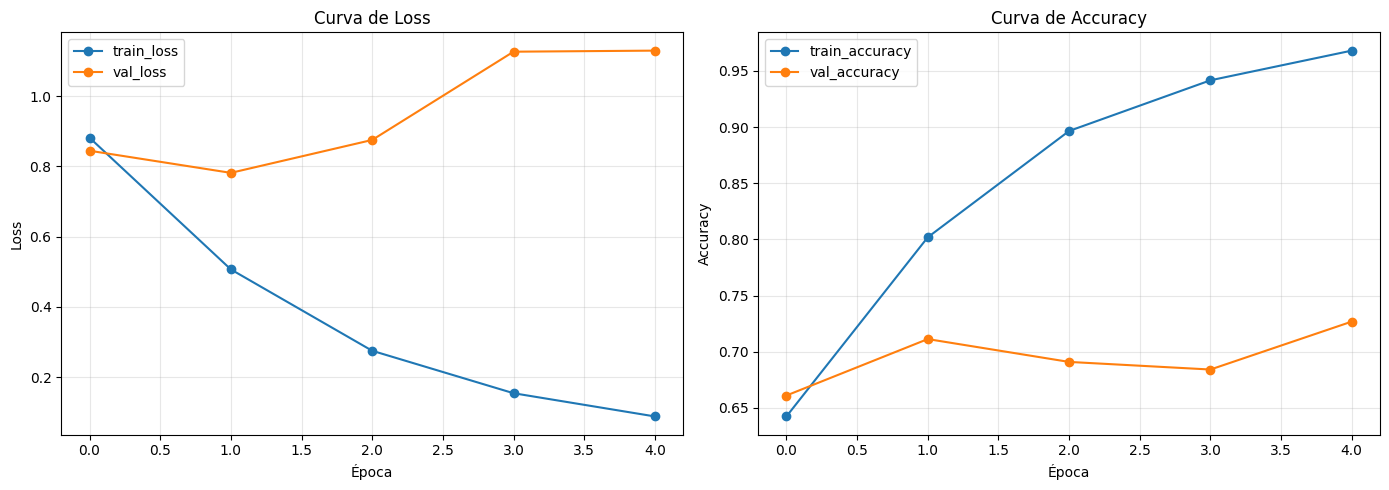

In [20]:
# Gráficas de train/val usando logs de Lightning.

metrics_path = Path(logger.log_dir) / "metrics.csv"
if not metrics_path.exists():
    raise FileNotFoundError(f"No se encontró metrics.csv en: {metrics_path}")

metrics_df = pd.read_csv(metrics_path)
print(f"Leyendo métricas desde: {metrics_path}")
print(f"Filas registradas: {len(metrics_df)}")


def _select_metric_column(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for col in candidates:
        if col in df.columns:
            return col
    return None


def _series_by_epoch(df: pd.DataFrame, col: str) -> pd.Series:
    tmp = df[["epoch", col]].dropna()
    if tmp.empty:
        return pd.Series(dtype=float)
    return tmp.groupby("epoch")[col].last()


train_loss_col = _select_metric_column(metrics_df, ["train_loss_epoch", "train_loss"])
val_loss_col = _select_metric_column(metrics_df, ["val_loss", "val_loss_epoch"])
train_acc_col = _select_metric_column(metrics_df, ["train_accuracy_epoch", "train_accuracy"])
val_acc_col = _select_metric_column(metrics_df, ["val_accuracy", "val_accuracy_epoch"])

if train_loss_col is None and val_loss_col is None:
    raise ValueError("No se encontraron columnas de loss para graficar.")

train_loss = _series_by_epoch(metrics_df, train_loss_col) if train_loss_col else pd.Series(dtype=float)
val_loss = _series_by_epoch(metrics_df, val_loss_col) if val_loss_col else pd.Series(dtype=float)
train_acc = _series_by_epoch(metrics_df, train_acc_col) if train_acc_col else pd.Series(dtype=float)
val_acc = _series_by_epoch(metrics_df, val_acc_col) if val_acc_col else pd.Series(dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot de loss.
if not train_loss.empty:
    axes[0].plot(train_loss.index, train_loss.values, marker="o", label="train_loss")
if not val_loss.empty:
    axes[0].plot(val_loss.index, val_loss.values, marker="o", label="val_loss")
axes[0].set_title("Curva de Loss")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Subplot de accuracy.
if not train_acc.empty:
    axes[1].plot(train_acc.index, train_acc.values, marker="o", label="train_accuracy")
if not val_acc.empty:
    axes[1].plot(val_acc.index, val_acc.values, marker="o", label="val_accuracy")
axes[1].set_title("Curva de Accuracy")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)
if not train_acc.empty or not val_acc.empty:
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, "No hay métricas de accuracy en logs", ha="center", va="center")

plt.tight_layout()
plt.show()


## 9) Métricas de evaluación (accuracy, precision, recall, F1)

En contexto de negocio (clasificación de retinopatía diabética), accuracy por sí sola no es suficiente. Con clases desbalanceadas, puede verse alta aunque el modelo falle en clases minoritarias.

Este bloque calcula métricas sobre `val_loader`:

- Accuracy
- Precision (macro y weighted)
- Recall (macro y weighted)
- F1 (macro y weighted)
- Reporte completo por clase

Guía simple de lectura:

- **Macro**: da el mismo peso a cada clase; muy importante para no ocultar bajo desempeño en minoritarias.
- **Weighted**: pondera por frecuencia; útil como referencia secundaria del desempeño global.

Para esta fase conviene priorizar **macro-F1** y **macro-recall**, usando accuracy como indicador de apoyo.


In [21]:
# Cálculo de métricas sobre validación.

model.eval()
all_targets: list[int] = []
all_preds: list[int] = []

# Reusar el dispositivo detectado en entrenamiento; fallback por seguridad.
eval_device = DEVICE if "DEVICE" in globals() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(eval_device)

with torch.no_grad():
    val_iterator = tqdm(
        val_loader,
        total=len(val_loader),
        desc="Evaluación",
        unit="batch",
        leave=False,
    )
    for (x1_batch, x2_batch), y_batch in val_iterator:
        x1_batch = x1_batch.to(eval_device)
        x2_batch = x2_batch.to(eval_device)
        y_batch = y_batch.to(eval_device)

        logits = model((x1_batch, x2_batch))
        preds = torch.argmax(logits, dim=1)

        all_targets.extend(y_batch.detach().cpu().tolist())
        all_preds.extend(preds.detach().cpu().tolist())

y_true = np.asarray(all_targets, dtype=np.int64)
y_pred = np.asarray(all_preds, dtype=np.int64)

acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average="macro",
    zero_division=0,
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average="weighted",
    zero_division=0,
)

print(f"Dispositivo de evaluación: {eval_device}")
print("=== Métricas de validación ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision macro: {prec_macro:.4f}")
print(f"Recall macro: {rec_macro:.4f}")
print(f"F1 macro: {f1_macro:.4f}")
print(f"Precision weighted: {prec_weighted:.4f}")
print(f"Recall weighted: {rec_weighted:.4f}")
print(f"F1 weighted: {f1_weighted:.4f}")
print()

print("=== Reporte por clase ===")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))


Evaluación:   0%|          | 0/40 [00:00<?, ?batch/s]

Dispositivo de evaluación: cuda
=== Métricas de validación ===
Accuracy: 0.7112
Precision macro: 0.5512
Recall macro: 0.5136
F1 macro: 0.5236
Precision weighted: 0.7140
Recall weighted: 0.7112
F1 weighted: 0.7060

=== Reporte por clase ===
              precision    recall  f1-score   support

           0     0.8584    0.7544    0.8031      1254
           1     0.2037    0.0873    0.1222       126
           2     0.6088    0.7746    0.6817       896
           3     0.4167    0.3125    0.3571        48
           4     0.6686    0.6393    0.6536       183

    accuracy                         0.7112      2507
   macro avg     0.5512    0.5136    0.5236      2507
weighted avg     0.7140    0.7112    0.7060      2507



## 10) Matriz de confusión con seaborn

Este bloque construye y visualiza la matriz de confusión del split de validación.

La matriz permite identificar qué clases se confunden entre sí (por ejemplo, niveles cercanos de severidad como leve vs moderado).

Desde negocio, esto es muy importante porque confundir casos severos con clases leves implica mayor riesgo clínico.

Se busca revisar:

- concentración en la diagonal (aciertos),
- errores sistemáticos fuera de diagonal (patrones de confusión repetidos).

Esta evidencia complementa macro-F1/macro-recall y ayuda a decidir próximos ajustes del pipeline.


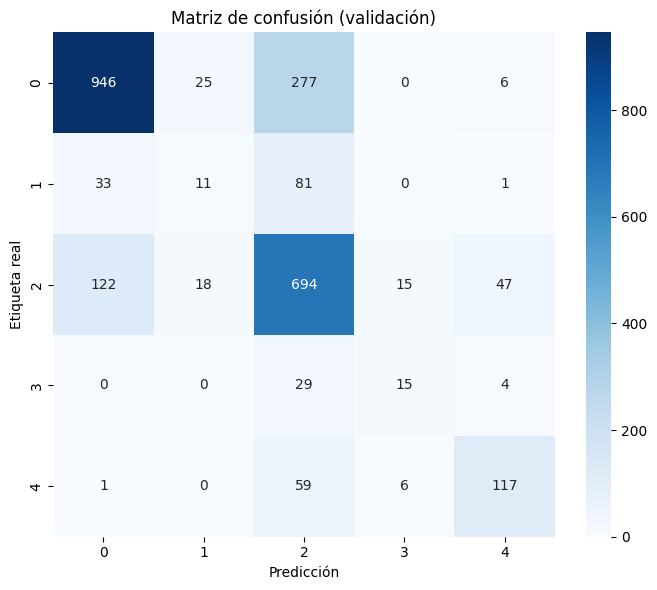

In [22]:
# Visualización de matriz de confusión.

labels_sorted = sorted(int(x) for x in np.unique(y_true))
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
)
plt.title("Matriz de confusión (validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


## 11) Conclusiones (baseline) y respuesta a las preguntas de la fase

### ¿Qué algoritmo usamos como baseline?

El baseline de referencia es **DenseNet-121 + XGBoost**. Conviene porque combina una extracción visual sólida con un clasificador rápido y estable, útil para el tipo de desbalance de datos que tenemos.

### ¿Podemos determinar importancia de características?

Sí. Se eligió XGBoost porque permite análisis embebido de importancia de características. Esto ayuda a identificar variables con mayor aporte y a reducir el efecto de señales irrelevantes.

### ¿Hay sobreajuste o subajuste?

Con la evidencia disponible en esta corrida, se observan señales de brecha entre desempeño global y desempeño por clase minoritaria (por ejemplo, macro-recall y macro-F1 por debajo de weighted, además de recalls bajos en clases minoritarias). Si en las curvas train vs val también aparece divergencia, eso refuerza hipótesis de sobreajuste; si ambas curvas quedan bajas, sugiere subajuste o señal limitada.

### ¿Qué métrica es adecuada para negocio?

Para clasificación de retinopatía diabética desbalanceada, conviene priorizar **macro-F1** y **macro-recall**. Accuracy se mantiene como indicador secundario.

### ¿Cuál debe ser el desempeño mínimo?

Muy importante: el modelo debe superar claramente un baseline ingenuo de **clase mayoritaria** (y se puede mencionar aleatorio solo como referencia). Si no supera ese umbral, la viabilidad del enfoque es cuestionable.

Comparar dos enfoques (simple vs complejo) vale la pena porque permite decidir con evidencia cuándo la complejidad adicional realmente aporta valor.

**Riesgos / desafíos**
- Generalización entre datasets y splits.
- Desbalance de clases en métricas por severidad.
- Costo de cómputo del modelo dual.
- Sensibilidad a diferencias de preprocesamiento entre backbones.

Este baseline queda como referencia para las siguientes iteraciones del proyecto.



Referencias:

- Nneji, G. U., Cai, J., Deng, J., Monday, H. N., Hossin, M. A., & Nahar, S. (2022). Identification of diabetic retinopathy using weighted fusion deep learning based on dual-channel fundus scans. Diagnostics, 12(2), 540.
- Meenakshi, K., Kishore, D., & Srinivasa Rao, C. (2024, October). Enhanced Detection of Diabetic Retinopathy Through Transfer Learning with DenseNet-121 and XGBoost Classifier. In International Conference on Computer & Communication Technologies (pp. 409-419). Singapore: Springer Nature Singapore.
- Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., y Plöd, M. (2023). CRISP-ML(Q). The ML Lifecycle Process. MLOps. INNOQ.